# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from itertools import count
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from collections import namedtuple, deque
import time

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

**Project description**: In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.
The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(2):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
``` 

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

## Only way for DDPG Actor class to work and work fast is with 2 layers. That way it can
## approximates deterministically the best action for any given state

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)   
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()        

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

## Critic neural network to evaluate the action value functionby using the "best" action coming from actor
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units) 
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    ## At this forward function the torch.cat method is the heart.    
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)    
        return x

## Hyperparameters

- BUFFER_SIZE = a buffer should be big for maximum experience for training.
- BATCH_SIZE = big batch size for more generic update during training.
- GAMMA = discount factor for Q values.
- TAU = controlling how much two neural networks should have similar weights.
- LR_ACTOR = learning rate of 1e-3 is one of the optimal learning rates for Adam optimizer.
- LR_CRITIC = learning rate of 1e-3 is one of the optimal learning rates for Adam optimizer.
- WEIGHT_DECAY = No weight decay is performing better in the DDPG implementation.
- NUM_OF_UPDATES = Number of learning updates
- UPDATE_EVERY = Every n time step do update

In [7]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
NUM_OF_UPDATES = 4      # number of learning updates
UPDATE_EVERY = 2        # every n time step do update

## DDPG Agent class

This is the place where we provide all the necessary info about the agent class and all the info about the DDPG algorithm. More details in Report.pdf

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""    
    
    agent_array = []
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        Agent.critic_local = Critic(state_size, action_size, random_seed).to(device)
        Agent.critic_target = Critic(state_size, action_size, random_seed).to(device)
        Agent.critic_optimizer = optim.Adam(Agent.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)        
        self.critic_local = Agent.critic_local
        self.critic_target = Agent.critic_target
        self.critic_optimizer = Agent.critic_optimizer

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        Agent.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

        # input every agent in array so we can access them
        self.agent_num=len(Agent.agent_array)
        Agent.agent_array.append(self)

    def step(self, time_step, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # input experiences
        Agent.memory.add(state, action, reward, next_state, done)
        # update every n time steps
        if time_step % UPDATE_EVERY != 0:
            return
        # learn, if memory exceeds batch size
        if len(Agent.memory) > BATCH_SIZE:
            for i in range(NUM_OF_UPDATES):
                experiences = Agent.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        # Clips gradient norm of an iterable of parameters.
        # https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html#clip_grad_norm_
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    # Lower the sigma, better for DDPG performance    
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.02):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Main DDPG function
Execute beolow to start training

In [9]:
def ddpg(n_episodes=1000, print_every=10):
    scores_deque = deque(maxlen=100)              
    avg_episode_scores = []
    agents =[]
    start_time = time.time()
    
    for i in range(num_agents):
        agents.append(Agent(state_size=state_size, action_size=action_size, random_seed=4))
    
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment        
        states = env_info.vector_observations                # get the current state
        
        for agent in agents:
            agent.reset()                                    # reset every agent
            
        score = 0     
        timestep = time.time()                               # get the current time
        time_step = 0
        
        while True:
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done        
            
            for i in range(num_agents):
                agents[i].step(time_step,states[i], actions[i], rewards[i], next_states[i], dones[i]) 
 
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break  
            time_step+=1
                
        score = np.max(scores)             # the score of the episode will be the maximum of 2 agent's scores
        scores_deque.append(score)         # add the score to the 100 episodes deque        
        avg_episode_scores.append(score)   # add the score to the total episodes' scores

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tTime per episode: {:.2f}'.format(i_episode, np.mean(scores_deque), time.time()-timestep))
        if np.mean(scores_deque) >= 0.5:
            print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}\tTotal time: {:.2f}'.format(i_episode, np.mean(scores_deque), time.time()-start_time))
            torch.save(Agent.agent_array[0].actor_local.state_dict(), 'checkpoint_first_actor.pth')
            torch.save(Agent.agent_array[1].actor_local.state_dict(), 'checkpoint_second_actor.pth')
            torch.save(Agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break   
    return avg_episode_scores

In [10]:
scores = ddpg()

Episode 10	Average Score: 0.00	Time per episode: 0.74
Episode 20	Average Score: 0.00	Time per episode: 0.70
Episode 30	Average Score: 0.00	Time per episode: 0.70
Episode 40	Average Score: 0.01	Time per episode: 1.52
Episode 50	Average Score: 0.02	Time per episode: 0.71
Episode 60	Average Score: 0.03	Time per episode: 7.15
Episode 70	Average Score: 0.04	Time per episode: 2.04
Episode 80	Average Score: 0.05	Time per episode: 1.54
Episode 90	Average Score: 0.06	Time per episode: 2.69
Episode 100	Average Score: 0.07	Time per episode: 5.73
Episode 110	Average Score: 0.10	Time per episode: 1.67
Episode 120	Average Score: 0.13	Time per episode: 21.55
Episode 130	Average Score: 0.16	Time per episode: 11.49
Episode 140	Average Score: 0.20	Time per episode: 2.73
Episode 150	Average Score: 0.25	Time per episode: 53.17
Episode 160	Average Score: 0.31	Time per episode: 45.97
Episode 170	Average Score: 0.38	Time per episode: 6.55
Episode 180	Average Score: 0.48	Time per episode: 20.26

 Environment 

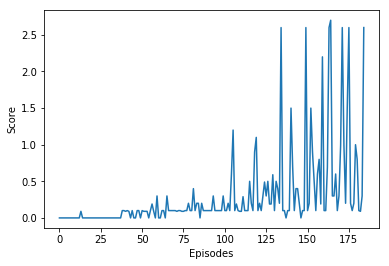

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

## Watch the agents
and play a game

In [15]:
agents =[] 

for i in range(num_agents):
    agents.append(Agent(state_size, action_size, random_seed=4))

agents[0].actor_local.load_state_dict(torch.load('checkpoint_first_actor.pth'))
agents[1].actor_local.load_state_dict(torch.load('checkpoint_second_actor.pth'))

In [17]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state
scores = np.zeros(num_agents)                          # initialize the score

while True:
    actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])
    env_info = env.step(actions)[brain_name]        # the action to the environment
    next_states = env_info.vector_observations      # the next state
    rewards = env_info.rewards                      # the reward
    dones = env_info.local_done        

    states = next_states
    scores += rewards
    
    if np.any(dones):
        break
        
print("\nScores: {}".format(scores))


Scores: [ 0.39000001  0.50000001]


When finished, you can close the environment.

In [18]:
env.close()